In [2]:
%pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_data(filepath: str) -> pd.DataFrame:
    """
    Carrega os dados do arquivo CSV e realiza transformações iniciais.
    
    Args:
        filepath: Caminho para o arquivo CSV
        
    Returns:
        DataFrame com os dados carregados e processados
    """
    df = pd.read_csv(
        filepath, 
        names=['arquivo', 'k', 'best_ans', 'tempo_ms'],
        header=None
    )
    
    return df

def load_data_vns(filepath: str) -> pd.DataFrame:
    """
    Carrega os dados do arquivo CSV do VNS Reativo e realiza transformações iniciais.
    
    Args:
        filepath: Caminho para o arquivo CSV
        
    Returns:
        DataFrame com os dados carregados e processados
    """
    df = pd.read_csv(
        filepath, 
        names=['arquivo', 'k', 'tempo_ms', 'best_ans'],
        header=None
    )
    
    return df

def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Realiza transformações nos dados, como conversão de tempo de ms para segundos.
    """
    df = df[df['tempo_ms'] <= 40000].copy()  # Filtra tempos maiores que 40 segundos
    df['tempo_seconds'] = df['tempo_ms'] / 1000.0
    return df

def print_dataset_info(df: pd.DataFrame) -> None:
    """Exibe informações resumidas sobre o dataset."""
    print(f"Total de registros: {len(df):,}")
    print(f"\nPrimeiras linhas:")
    print(df.head())
    print(f"\nEstatísticas:")
    print(df[['best_ans', 'tempo_seconds']].describe())

# Carregar dados
df_aco = load_data('../Results/aco_kmis/result-2.csv')
df_graspts = load_data('../Results/graspts/result-2.csv')
df_vns = load_data_vns('../Results/vns_reactive/result-1.csv')

# Transformar dados
df_aco = transform_data(df_aco)
df_graspts = transform_data(df_graspts)
df_vns = transform_data(df_vns)

# Exibir informações dos datasets
print_dataset_info(df_aco)
print("-------------")
print_dataset_info(df_graspts)
print("-------------")
print_dataset_info(df_vns)

Total de registros: 325,964

Primeiras linhas:
                                arquivo   k  best_ans  tempo_ms  tempo_seconds
0  ./Dataset/type1/classe_1_100_100.txt  11         6      30.0          0.030
1  ./Dataset/type1/classe_1_100_100.txt  11         6      60.0          0.060
2  ./Dataset/type1/classe_1_100_100.txt  11         7      91.0          0.091
3  ./Dataset/type1/classe_1_100_100.txt  11         7     122.0          0.122
4  ./Dataset/type1/classe_1_100_100.txt  11         7     153.0          0.153

Estatísticas:
            best_ans  tempo_seconds
count  325964.000000  325964.000000
mean       23.657293      19.984705
std        25.004787      11.542778
min         0.000000       0.002000
25%         3.000000       9.985000
50%        19.000000      19.974000
75%        40.000000      29.978000
max       233.000000      40.000000
-------------
Total de registros: 3,193,846

Primeiras linhas:
                                arquivo   k  best_ans  tempo_ms  tempo_second

## Análise Comparativa: Evolução das Soluções

In [4]:
def prepare_time_series_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepara dados de série temporal com preenchimento de valores ausentes.
    Otimizado usando operações vetorizadas do pandas.
    
    Args:
        df: DataFrame original com dados
        
    Returns:
        DataFrame com médias por instância e grupo de tempo
    """
    # Ordenar por tempo e criar coluna arredondada para diminuir granularidade
    df_sorted = df.sort_values('tempo_ms').copy()
    df_sorted['tempo_seconds_arounded'] = df_sorted['tempo_seconds'].round(3).copy()
    
    # Agrupar por instância e tempo arredondado, calculando o máximo do best_ans, já que queremos o melhor valor encontrado até aquele tempo
    df_grouped = df_sorted.groupby(
        ['arquivo', 'tempo_seconds_arounded'], 
        as_index=False
    ).agg({'best_ans': 'mean'})
    
    print(f"Grouped structure 10 head:\n{df_grouped.head(10)}")
    
    # Criar índice completo (todas combinações de instância x tempo), para garantir que todos os tempos estejam representados
    instances = df['arquivo'].unique().copy()
    time_groups = df_sorted['tempo_seconds_arounded'].unique().copy()
    
    # Criar MultiIndex com todas as combinações ordenadas, para garantir consistência
    full_index = pd.MultiIndex.from_product(
        [instances, sorted(time_groups)],
        names=['arquivo', 'tempo_seconds_arounded']
    )
    
    # Reindexar para incluir todas as combinações, para preencher valores ausentes posteriormente
    # E usando ffill para propagar o último valor conhecido de best_ans para frente dentro de cada instância
    # Valores ausentes iniciais são preenchidos com 0
    df_complete = df_grouped.set_index(['arquivo', 'tempo_seconds_arounded']).reindex(full_index)
    df_complete = df_complete.sort_index()
    df_complete['best_ans'] = df_complete.groupby(level='arquivo')['best_ans'].ffill().fillna(0)
    
    # Resetar índice e adicionar colunas auxiliares, para manter consistência com o formato original
    df_result = df_complete.reset_index().copy()
    df_result['tempo_seconds'] = df_result['tempo_seconds_arounded'].copy()
    df_result['tempo_ms'] = df_result['tempo_seconds'] * 1000.0
    df_result['k'] = 0  # Coluna k não é relevante para esta análise, definir como 0
    
    # Reordenar colunas para manter consistência
    df_result = df_result[['arquivo', 'k', 'best_ans', 'tempo_ms', 'tempo_seconds', 'tempo_seconds_arounded']]
    
    return df_result

In [5]:
df_instances_mean_by_group_time_aco = prepare_time_series_data(df_aco).copy()
df_instances_mean_by_group_time_aco.head()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type1/classe_1_100_100.txt                   0.030       6.0
1  ./Dataset/type1/classe_1_100_100.txt                   0.060       6.0
2  ./Dataset/type1/classe_1_100_100.txt                   0.091       7.0
3  ./Dataset/type1/classe_1_100_100.txt                   0.122       7.0
4  ./Dataset/type1/classe_1_100_100.txt                   0.153       7.0
5  ./Dataset/type1/classe_1_100_100.txt                   0.184       7.0
6  ./Dataset/type1/classe_1_100_100.txt                   0.215       7.0
7  ./Dataset/type1/classe_1_100_100.txt                   0.246       7.0
8  ./Dataset/type1/classe_1_100_100.txt                   0.277       7.0
9  ./Dataset/type1/classe_1_100_100.txt                   0.308       7.0


,arquivo,k,best_ans,tempo_ms,tempo_seconds,tempo_seconds_arounded
0,./Dataset/type1/classe_1_100_100.txt,0,0.0,2.0,0.002,0.002
1,./Dataset/type1/classe_1_100_100.txt,0,0.0,3.0,0.003,0.003
2,./Dataset/type1/classe_1_100_100.txt,0,0.0,4.0,0.004,0.004
3,./Dataset/type1/classe_1_100_100.txt,0,0.0,5.0,0.005,0.005
4,./Dataset/type1/classe_1_100_100.txt,0,0.0,6.0,0.006,0.006


In [6]:
df_instances_mean_by_group_time_graspts =prepare_time_series_data(df_graspts).copy()
df_instances_mean_by_group_time_graspts.head()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type1/classe_1_100_100.txt                   0.000  5.645161
1  ./Dataset/type1/classe_1_100_100.txt                   0.001  5.000000
2  ./Dataset/type1/classe_1_100_100.txt                   0.002  5.000000
3  ./Dataset/type1/classe_1_100_100.txt                   0.012  6.000000
4  ./Dataset/type1/classe_1_100_100.txt                   0.221  7.000000
5  ./Dataset/type1/classe_1_140_140.txt                   0.000  3.105263
6  ./Dataset/type1/classe_1_140_140.txt                   0.004  3.000000
7  ./Dataset/type1/classe_1_140_140.txt                   0.018  4.000000
8  ./Dataset/type1/classe_1_140_140.txt                   0.061  4.000000
9  ./Dataset/type1/classe_1_140_140.txt                   0.103  4.000000


,arquivo,k,best_ans,tempo_ms,tempo_seconds,tempo_seconds_arounded
0,./Dataset/type1/classe_1_100_100.txt,0,5.645161,0.0,0.000,0.000
1,./Dataset/type1/classe_1_100_100.txt,0,5.000000,1.0,0.001,0.001
2,./Dataset/type1/classe_1_100_100.txt,0,5.000000,2.0,0.002,0.002
3,./Dataset/type1/classe_1_100_100.txt,0,5.000000,3.0,0.003,0.003
4,./Dataset/type1/classe_1_100_100.txt,0,5.000000,4.0,0.004,0.004


In [7]:

df_instances_mean_by_group_time_vns = prepare_time_series_data(df_vns).copy()
df_instances_mean_by_group_time_vns.head()

Grouped structure 10 head:
            arquivo  tempo_seconds_arounded  best_ans
0  classe_10_200_72                   0.000       1.0
1  classe_10_200_72                   0.001       1.0
2  classe_10_200_72                   0.002       1.0
3  classe_10_200_72                   0.003       1.0
4  classe_10_200_72                   0.004       1.0
5  classe_10_200_72                   0.005       1.0
6  classe_10_200_72                   0.006       1.0
7  classe_10_200_72                   0.007       1.0
8  classe_10_200_72                   0.008       1.0
9  classe_10_200_72                   0.009       1.0


,arquivo,k,best_ans,tempo_ms,tempo_seconds,tempo_seconds_arounded
0,classe_10_200_72,0,1.0,0.0,0.000,0.000
1,classe_10_200_72,0,1.0,1.0,0.001,0.001
2,classe_10_200_72,0,1.0,2.0,0.002,0.002
3,classe_10_200_72,0,1.0,3.0,0.003,0.003
4,classe_10_200_72,0,1.0,4.0,0.004,0.004


# Plotar gráfico da média do best_ans ao longo do tempo

## Gráfico para o ACO

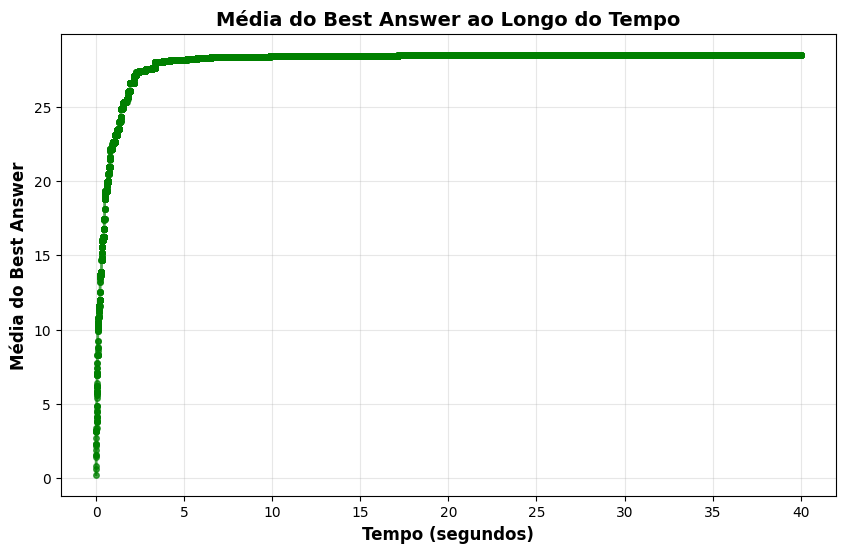

In [8]:
# Plotar gráfico da média do best_ans ao longo do tempo
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans = df_instances_mean_by_group_time_aco.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans['tempo_seconds_arounded'], mean_best_ans['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='green')
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type4/classe_10_200_66.txt                   0.244       0.0
1  ./Dataset/type4/classe_10_200_66.txt                   0.498       0.0
2  ./Dataset/type4/classe_10_200_72.txt                   0.104       1.0
3  ./Dataset/type4/classe_10_200_72.txt                   0.210       1.0
4  ./Dataset/type4/classe_10_200_72.txt                   0.316       1.0
5  ./Dataset/type4/classe_10_200_72.txt                   0.422       1.0
6  ./Dataset/type4/classe_10_200_74.txt                   0.256       0.0
7  ./Dataset/type4/classe_10_200_75.txt                   0.123       1.0
8  ./Dataset/type4/classe_10_200_75.txt                   0.248       1.0
9  ./Dataset/type4/classe_10_200_75.txt                   0.373       1.0


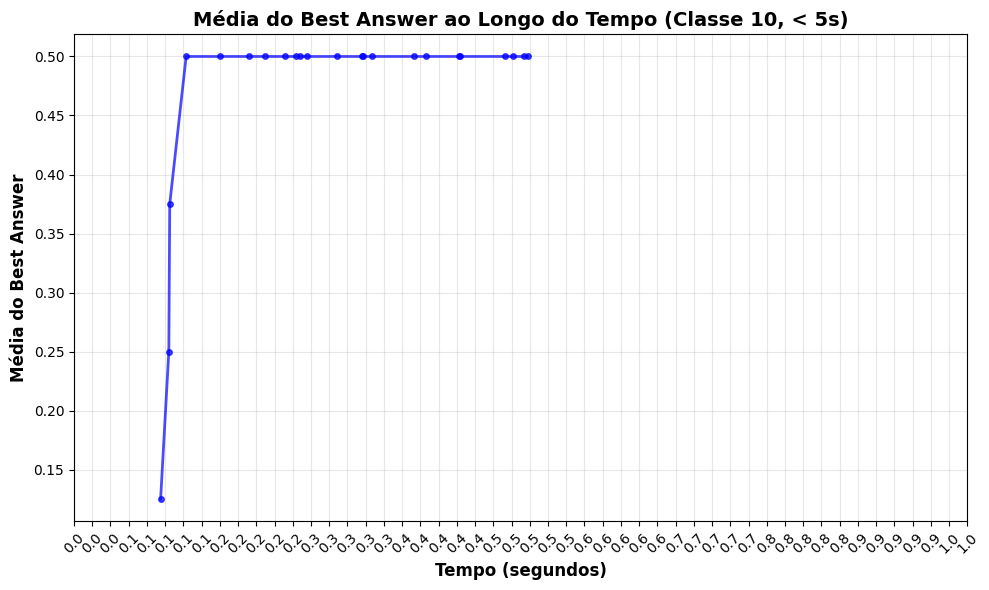

In [9]:
# Plotar gráfico da média do best_ans somente para instancia da classe 10

df_class_10 = df_aco[(df_aco['arquivo'].str.contains('classe_10')) & (df_aco['tempo_seconds'] < 0.5)]
df_instances_mean_by_group_time_class_10 = prepare_time_series_data(df_class_10).copy()
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans_class_10 = df_instances_mean_by_group_time_class_10.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans_class_10['tempo_seconds_arounded'], mean_best_ans_class_10['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='blue')
# labels do tempo em intervalo de 0.5 em 0.5 segundos
labels = np.arange(0, mean_best_ans_class_10['tempo_seconds_arounded'].max() + 0.5, 0.02)
axes.set_xticks(labels)
axes.set_xticklabels([f'{x:.1f}' for x in labels], rotation=45)
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo (Classe 10, < 5s)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Plotar gráfico do GRASPTS

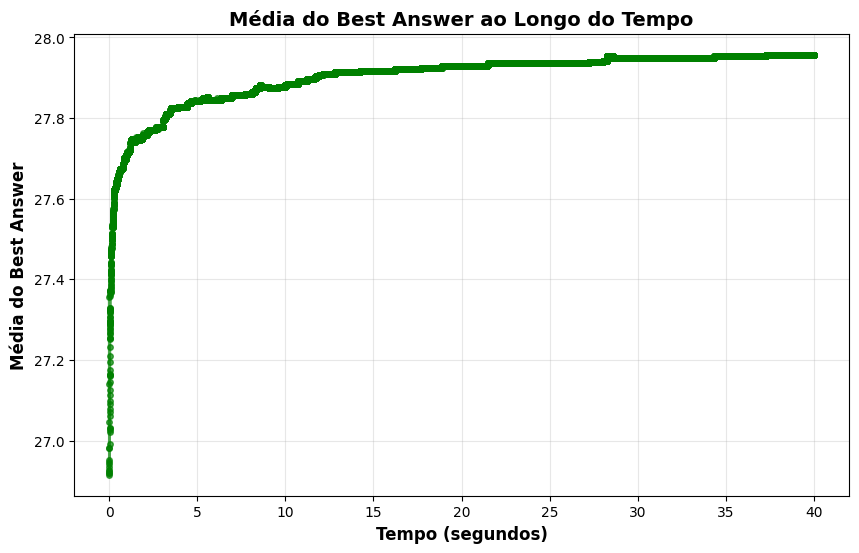

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans = df_instances_mean_by_group_time_graspts.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans['tempo_seconds_arounded'], mean_best_ans['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='green')
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type4/classe_10_200_66.txt                   0.244       0.0
1  ./Dataset/type4/classe_10_200_66.txt                   0.498       0.0
2  ./Dataset/type4/classe_10_200_66.txt                   0.751       0.0
3  ./Dataset/type4/classe_10_200_72.txt                   0.104       1.0
4  ./Dataset/type4/classe_10_200_72.txt                   0.210       1.0
5  ./Dataset/type4/classe_10_200_72.txt                   0.316       1.0
6  ./Dataset/type4/classe_10_200_72.txt                   0.422       1.0
7  ./Dataset/type4/classe_10_200_72.txt                   0.528       1.0
8  ./Dataset/type4/classe_10_200_72.txt                   0.634       1.0
9  ./Dataset/type4/classe_10_200_72.txt                   0.741       1.0


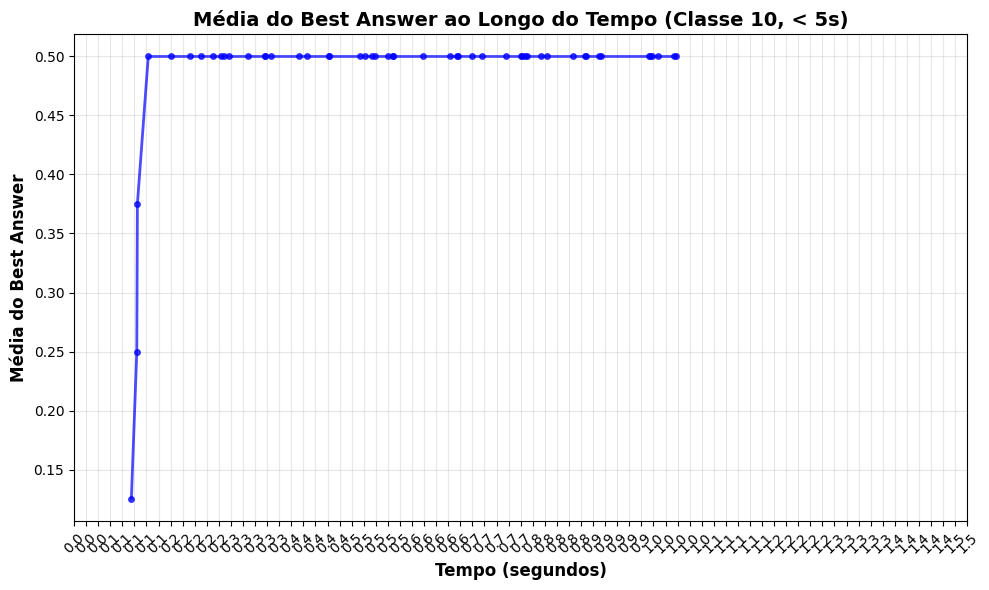

In [11]:
# Plotar gráfico da média do best_ans ao longo do tempo para classe 10 - GRASPts

df_class_10 = df_aco[(df_aco['arquivo'].str.contains('classe_10')) & (df_aco['tempo_seconds'] < 1)]
df_instances_mean_by_group_time_class_10 = prepare_time_series_data(df_class_10)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans_class_10 = df_instances_mean_by_group_time_class_10.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans_class_10['tempo_seconds_arounded'], mean_best_ans_class_10['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='blue')
# labels do tempo em intervalo de 0.5 em 0.5 segundos
labels = np.arange(0, mean_best_ans_class_10['tempo_seconds_arounded'].max() + 0.5, 0.02)
axes.set_xticks(labels)
axes.set_xticklabels([f'{x:.1f}' for x in labels], rotation=45)
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo (Classe 10, < 5s)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Plotar gráfico VNS Reativo

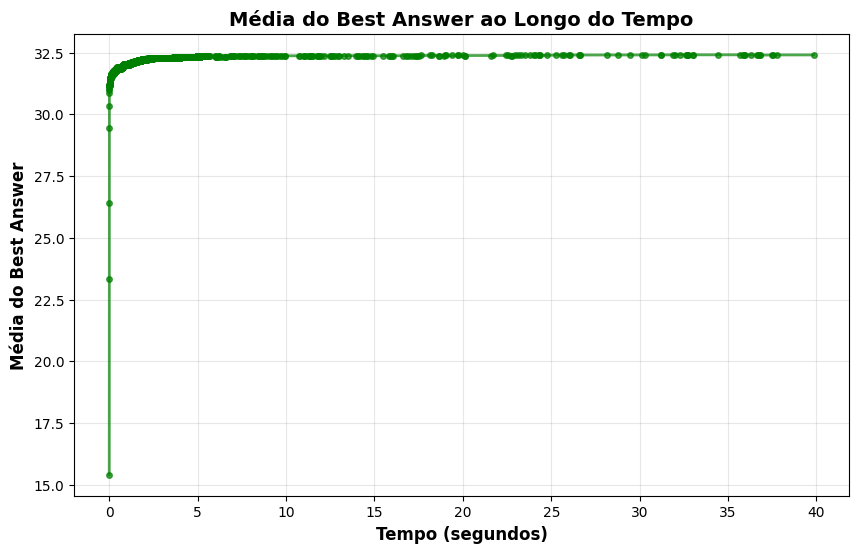

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans = df_instances_mean_by_group_time_vns.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans['tempo_seconds_arounded'], mean_best_ans['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='green')
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type4/classe_10_200_66.txt                   0.244       0.0
1  ./Dataset/type4/classe_10_200_66.txt                   0.498       0.0
2  ./Dataset/type4/classe_10_200_72.txt                   0.104       1.0
3  ./Dataset/type4/classe_10_200_72.txt                   0.210       1.0
4  ./Dataset/type4/classe_10_200_72.txt                   0.316       1.0
5  ./Dataset/type4/classe_10_200_72.txt                   0.422       1.0
6  ./Dataset/type4/classe_10_200_74.txt                   0.256       0.0
7  ./Dataset/type4/classe_10_200_75.txt                   0.123       1.0
8  ./Dataset/type4/classe_10_200_75.txt                   0.248       1.0
9  ./Dataset/type4/classe_10_200_75.txt                   0.373       1.0


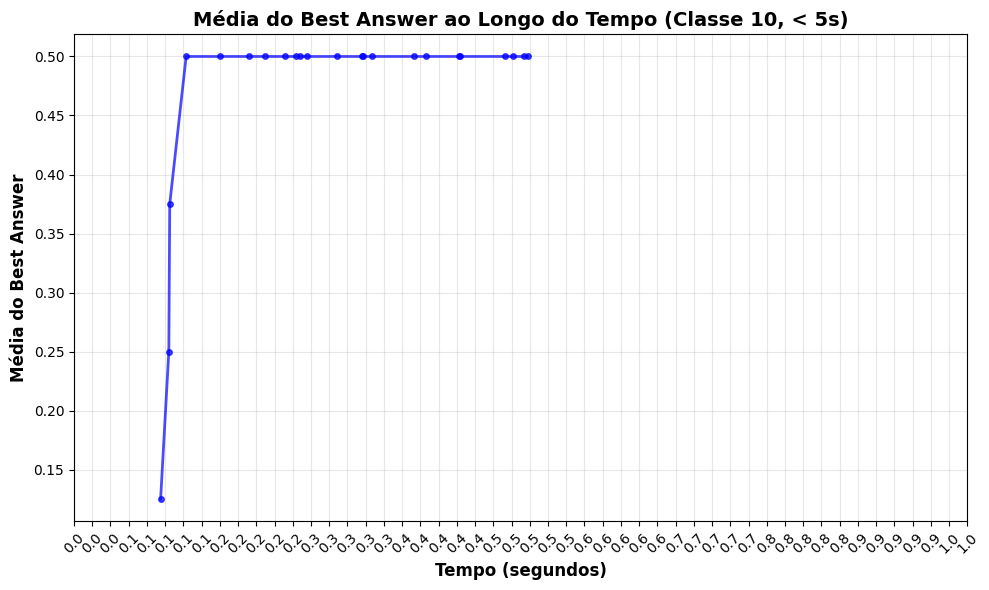

In [13]:
# Plotar gráfico da média do best_ans ao longo do tempo para a classe 10 - VNS Reativo

df_class_10 = df_aco[(df_aco['arquivo'].str.contains('classe_10')) & (df_aco['tempo_seconds'] < 0.5)]
df_instances_mean_by_group_time_class_10 = prepare_time_series_data(df_class_10)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans_class_10 = df_instances_mean_by_group_time_class_10.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans_class_10['tempo_seconds_arounded'], mean_best_ans_class_10['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='blue')
# labels do tempo em intervalo de 0.5 em 0.5 segundos
labels = np.arange(0, mean_best_ans_class_10['tempo_seconds_arounded'].max() + 0.5, 0.02)
axes.set_xticks(labels)
axes.set_xticklabels([f'{x:.1f}' for x in labels], rotation=45)
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo (Classe 10, < 5s)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Calcular gráfico comparativo

Shape final: (625560, 4)
Registros ACO: 11,119,444
Registros GRASPTS: 11,120,278
Registros VNS: 1,299,056

Primeiras linhas:
                                arquivo  tempo_seconds_arounded algoritmo  \
0  ./Dataset/type1/classe_1_100_100.txt                     0.0       ACO   
1  ./Dataset/type1/classe_1_100_100.txt                     0.0   GRASPTS   
2  ./Dataset/type1/classe_1_100_100.txt                     0.0       VNS   
3  ./Dataset/type1/classe_1_100_100.txt                     0.1       ACO   
4  ./Dataset/type1/classe_1_100_100.txt                     0.1   GRASPTS   
5  ./Dataset/type1/classe_1_100_100.txt                     0.1       VNS   
6  ./Dataset/type1/classe_1_100_100.txt                     0.2       ACO   
7  ./Dataset/type1/classe_1_100_100.txt                     0.2   GRASPTS   
8  ./Dataset/type1/classe_1_100_100.txt                     0.2       VNS   
9  ./Dataset/type1/classe_1_100_100.txt                     0.3       ACO   

   best_ans  
0  2.571429  

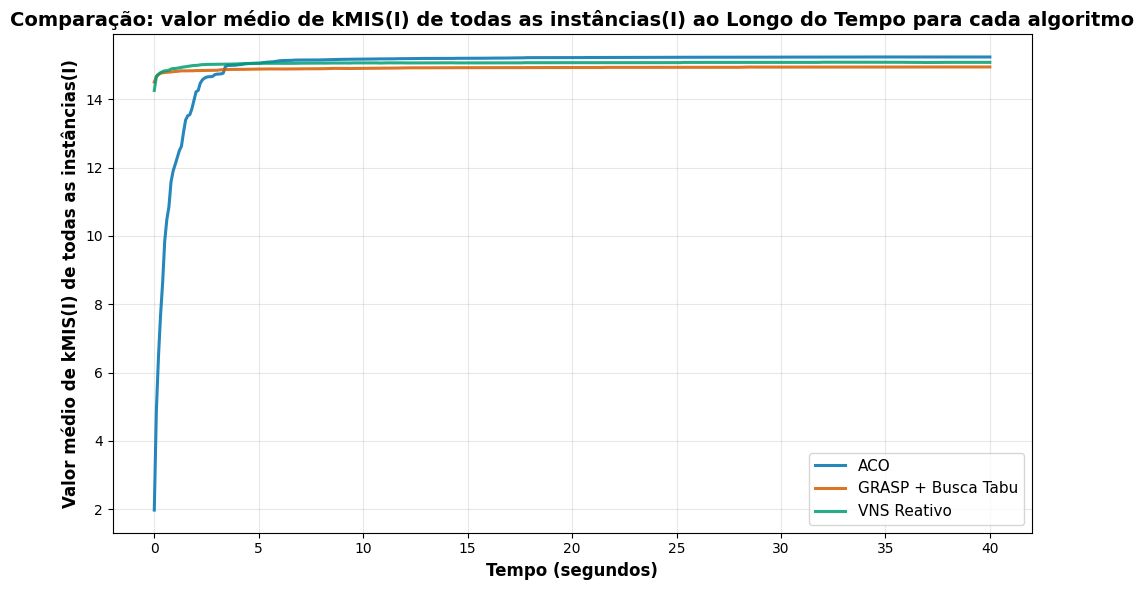

In [14]:
def concat_dfs_with_prefix(df_aco: pd.DataFrame, df_graspts: pd.DataFrame, df_vns: pd.DataFrame) -> pd.DataFrame:
    """
    Concatena ACO, GRASPTS e VNS DataFrames verticalmente, adicionando coluna de origem.

    Args:
        df_aco: DataFrame com dados do ACO
        df_graspts: DataFrame com dados do GRASPTS
        df_vns: DataFrame com dados do VNS

    Returns:
        DataFrame concatenado com coluna 'algoritmo' identificando a origem
    """
    # Adicionar coluna de origem em cada DataFrame
    df_aco_copy = df_aco.copy()
    df_aco_copy['algoritmo'] = 'ACO'

    df_vns_copy = df_vns.copy()
    df_vns_copy['algoritmo'] = 'VNS'

    df_graspts_copy = df_graspts.copy()
    df_graspts_copy['algoritmo'] = 'GRASPTS'
    
    # Concatenar verticalmente (empilhar)
    df_concat = pd.concat([df_aco_copy, df_vns_copy, df_graspts_copy], ignore_index=True)

    # ARREDONDAR os tempos para reduzir o número de grupos e evitar explosão de memória
    df_concat['tempo_seconds_arounded'] = df_concat['tempo_seconds_arounded'].round(1).copy()  # arredonda para o inteiro mais próximo

    # Garantir unicidade para o índice composto
    df_concat = df_concat.groupby(['arquivo', 'tempo_seconds_arounded', 'algoritmo'], as_index=False)['best_ans'].mean().copy()

    # Juntar os "tempo_seconds_arounded" dos algoritmos
    all_item_intervals = sorted(df_concat['tempo_seconds_arounded'].unique())

    # Garantir que todos os tempos estejam presentes para todos os algoritmos
    full_index = pd.MultiIndex.from_product(
        [df_concat['arquivo'].unique(), all_item_intervals, ['ACO', 'VNS', 'GRASPTS']],
        names=['arquivo', 'tempo_seconds_arounded', 'algoritmo']
    )

    # Preencher valores ausentes com o último valor válido menor que o tempo a ser preenchido ou zero
    df_concat = df_concat.set_index(
        ['arquivo', 'tempo_seconds_arounded', 'algoritmo']
    ).reindex(full_index)
    

    df_concat['best_ans'] = df_concat.groupby(level=['arquivo', 'algoritmo'])['best_ans'].ffill().fillna(0)
    
    # Para as instâncias que estão repetidas dentro de um grupo de tempo, deve tirar a média desses resultados para evitar distorções
    df_concat = df_concat.groupby(level=['arquivo', 'tempo_seconds_arounded', 'algoritmo'])['best_ans'].mean().to_frame()
    
    df_concat = df_concat.reset_index() 

    print(f"Shape final: {df_concat.shape}")
    print(f"Registros ACO: {len(df_aco_copy):,}")
    print(f"Registros GRASPTS: {len(df_graspts_copy):,}")
    print(f"Registros VNS: {len(df_vns_copy):,}")
    print(f"\nPrimeiras linhas:\n{df_concat.head(10)}")

    return df_concat

# Concatenar os DataFrames
df_combined = concat_dfs_with_prefix(
    df_instances_mean_by_group_time_aco,
    df_instances_mean_by_group_time_graspts,
    df_instances_mean_by_group_time_vns
)


# Calcular médias por algoritmo e tempo
df_plot = df_combined.groupby(['algoritmo', 'tempo_seconds_arounded'])[
    'best_ans'].mean().reset_index()

# Plotar gráfico comparativo com cores modernas e acessíveis
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# Paleta de cores mais agradável e acessível
color_map = {
    'ACO': '#0072B2',      # azul escuro
    'GRASPTS': '#D55E00',  # laranja escuro
    'VNS': '#009E73'       # verde escuro
}
marker_map = {
    'ACO': 'o',
    'GRASPTS': 's',
    'VNS': '^'
}

label_map = {
    'ACO': 'ACO',
    'GRASPTS': 'GRASP + Busca Tabu',
    'VNS': 'VNS Reativo'
}

for algoritmo in ['ACO', 'GRASPTS', 'VNS']:
    df_alg = df_plot[df_plot['algoritmo'] == algoritmo]
    axes.plot(df_alg['tempo_seconds_arounded'], df_alg['best_ans'], alpha=0.85, linewidth=2.2,
              color=color_map[algoritmo], label=label_map[algoritmo])
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Valor médio de kMIS(I) de todas as instâncias(I)', fontsize=12, fontweight='bold')
max_tempo = df_plot['tempo_seconds_arounded'].max()
# axes.set_xticks(np.arange(0, max_tempo + 1, 3))
axes.set_title('Comparação: valor médio de kMIS(I) de todas as instâncias(I) ao Longo do Tempo para cada algoritmo',
               fontsize=14, fontweight='bold')
axes.legend(fontsize=11, frameon=True, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
df_combined[df_combined['algoritmo'] == 'ACO']['best_ans'].mean()

np.float64(14.959681495745418)

In [18]:
df_combined[df_combined['algoritmo'] == 'VNS']['best_ans'].mean()

np.float64(15.058259102417264)

In [19]:
df_combined[df_combined['algoritmo'] == 'GRASPTS']['best_ans'].mean()

np.float64(14.91670556272903)

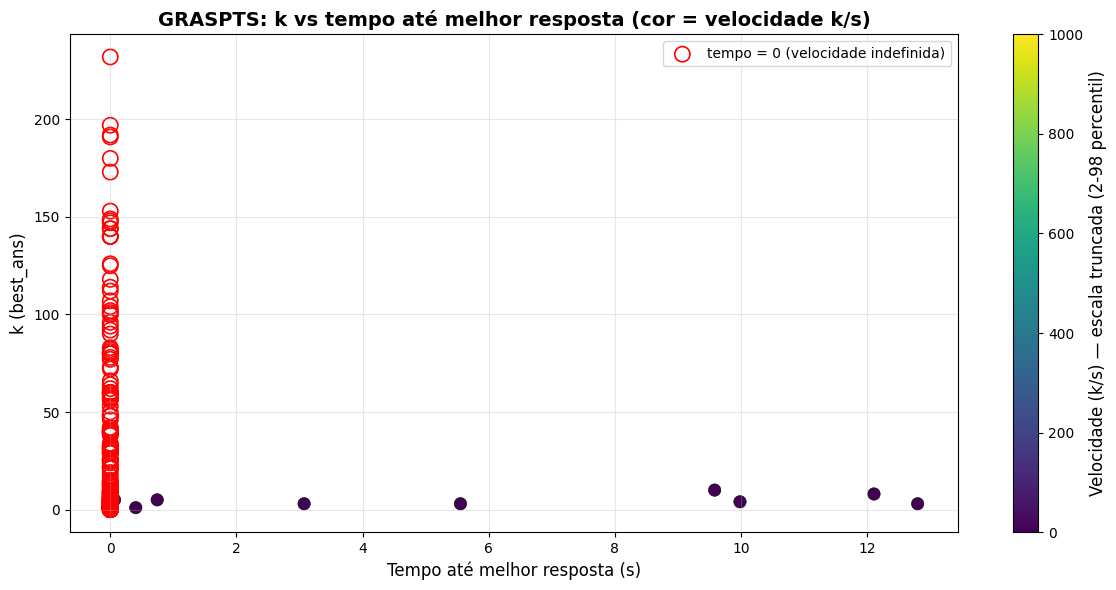

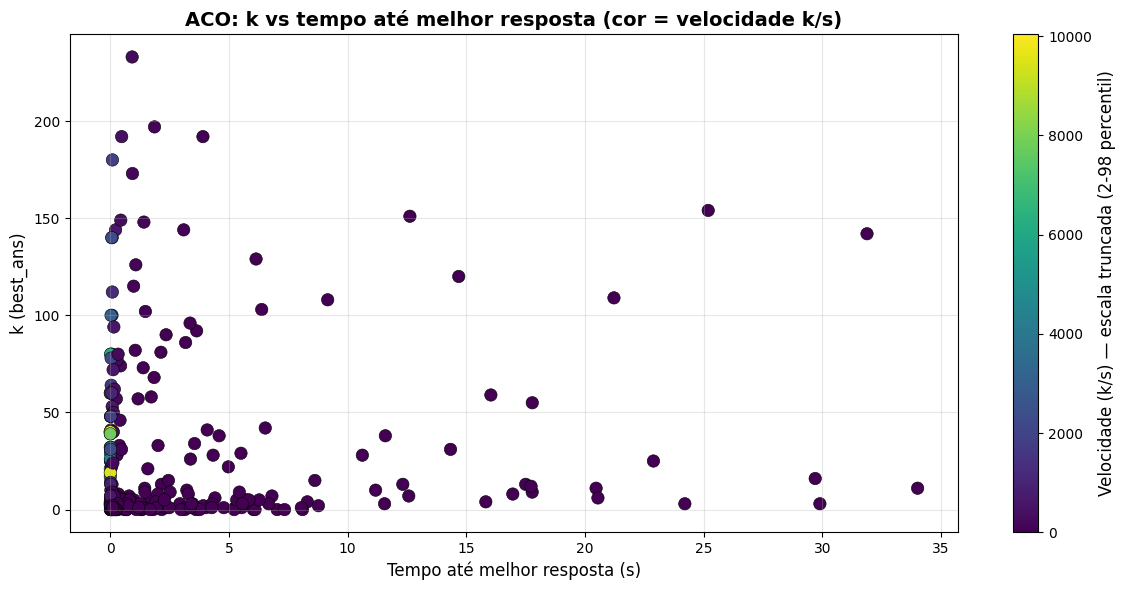

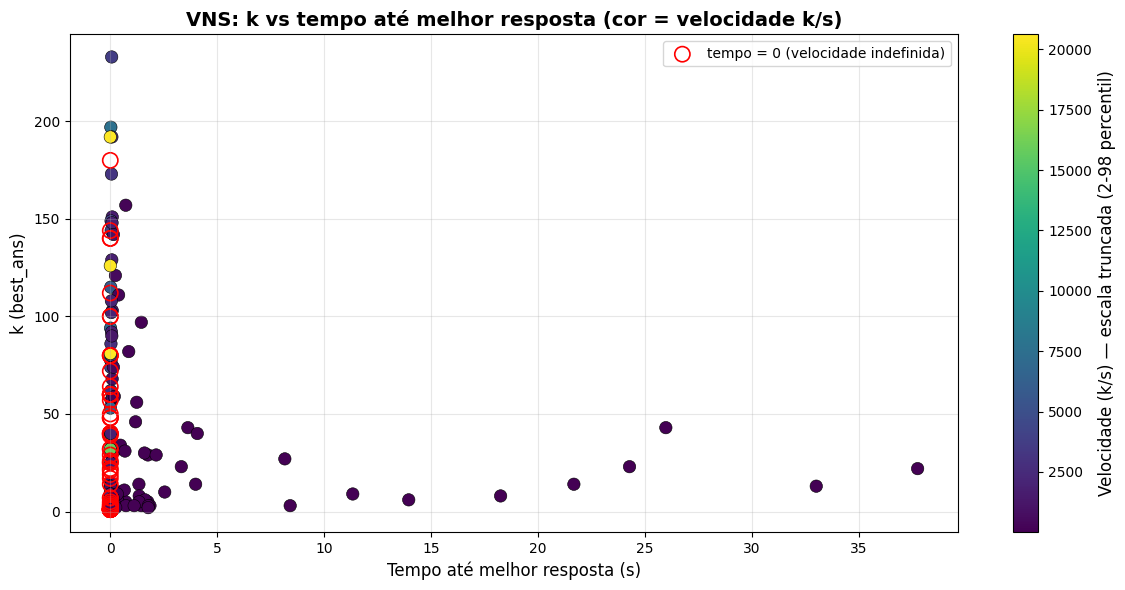

In [22]:
def tempo_velocidade_melhor_resposta(df: pd.DataFrame, nome_algoritmo: str) -> None:
  """
  Plota k (best_ans) vs tempo até a melhor resposta, colorindo pela velocidade (k / tempo).
  Observação: respeita a natureza temporal — em caso de empate no best_ans escolhe o primeiro
  (menor tempo).
  """
  # garantir ordenação temporal para desempates corretos
  if 'tempo_seconds' not in df.columns:
    raise ValueError("DataFrame precisa da coluna 'tempo_seconds' (tempo em segundos).")
  df_sorted = df.sort_values(['arquivo', 'tempo_seconds']).copy()
  
  # calcular o melhor best_ans por instância (arquivo)
  best_per_file = df_sorted.groupby('arquivo', as_index=False)['best_ans'].max().rename(columns={'best_ans': 'best_ans_max'})
  df_merged = df_sorted.merge(best_per_file, on='arquivo', how='left')
  
  # filtrar linhas que atingem o melhor valor e pegar a primeira (menor tempo)
  df_best = df_merged[df_merged['best_ans'] == df_merged['best_ans_max']].copy()
  df_best = df_best.sort_values(['arquivo', 'tempo_seconds']).groupby('arquivo', as_index=False).first()
  
  # tempo até o melhor e velocidade (tratando tempos zero)
  df_best['tempo_ate_melhor'] = df_best['tempo_seconds'].astype(float)
  # evitar divisão por zero: marcar como NaN (interpretação: velocidade indefinida/infinita)
  df_best['velocidade'] = df_best['best_ans'] / df_best['tempo_ate_melhor'].replace({0.0: np.nan})
  velocidade = df_best['velocidade'].replace([np.inf, -np.inf], np.nan)
  
  # preparar limites da cor para evitar impacto de outliers (usar percentile)
  valid = velocidade.dropna()
  if len(valid) == 0:
    vmin, vmax = 0, 1
  else:
    try:
      vmin, vmax = np.nanpercentile(valid, [2, 98])
      if vmin == vmax:
        vmin, vmax = valid.min(), valid.max()
    except Exception:
      vmin, vmax = valid.min(), valid.max()
  
  fig, ax = plt.subplots(figsize=(12, 6))
  sc = ax.scatter(
    df_best['tempo_ate_melhor'],
    df_best['best_ans'],
    c=velocidade,
    cmap='viridis',
    s=80,
    edgecolor='k',
    linewidth=0.4,
    vmin=vmin,
    vmax=vmax
  )
  ax.set_xlabel('Tempo até melhor resposta (s)', fontsize=12)
  ax.set_ylabel('k (best_ans)', fontsize=12)
  ax.set_title(f'{nome_algoritmo}: k vs tempo até melhor resposta (cor = velocidade k/s)', fontsize=14, fontweight='bold')
  cbar = plt.colorbar(sc, ax=ax)
  cbar.set_label('Velocidade (k/s) — escala truncada (2-98 percentil)', fontsize=12)
  # destacar pontos com tempo zero (velocidade indefinida) caso existam
  zeros = df_best['tempo_ate_melhor'] == 0
  if zeros.any():
    ax.scatter(
      df_best.loc[zeros, 'tempo_ate_melhor'],
      df_best.loc[zeros, 'best_ans'],
      facecolors='none',
      edgecolors='red',
      s=120,
      linewidth=1.2,
      label='tempo = 0 (velocidade indefinida)'
    )
    ax.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

# Chamadas para cada algoritmo
tempo_velocidade_melhor_resposta(df_graspts, 'GRASPTS')
tempo_velocidade_melhor_resposta(df_aco, 'ACO')
tempo_velocidade_melhor_resposta(df_vns, 'VNS')


## CDF do tempo até a melhor solução (instâncias `classe_10`)

Este gráfico mostra, para cada algoritmo, a fração de instâncias da `classe_10` que já alcançaram a sua melhor solução em um dado tempo t. É útil para avaliar a velocidade com que cada algoritmo converge para sua melhor solução.


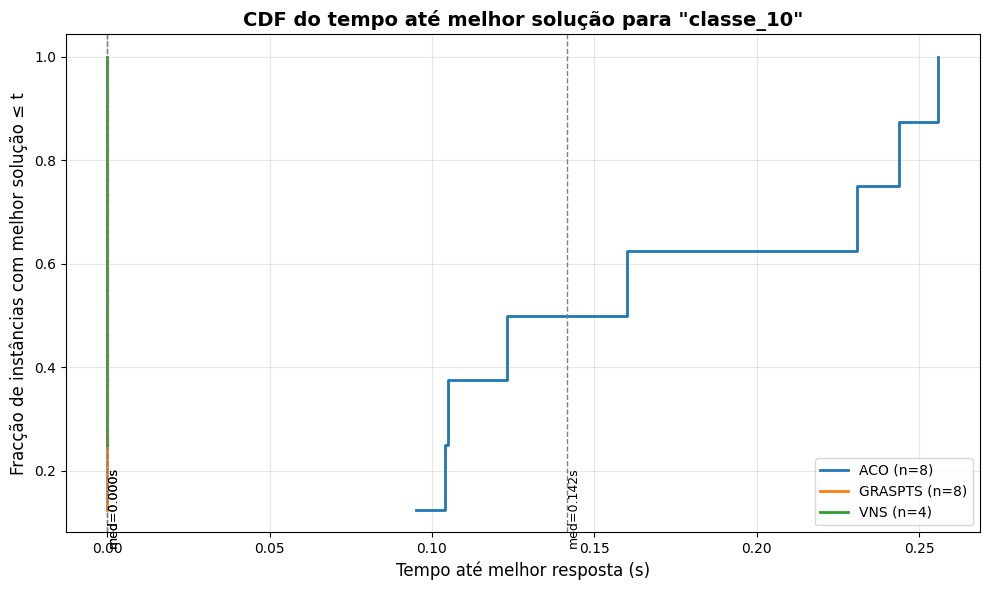

In [24]:
def plot_cdf_time_to_best_for_class(df_list, class_pattern='classe_10'):
    """
    Plota CDF (fração de instâncias que alcançaram sua melhor solução até t)
    para cada algoritmo, restrito às instâncias que contêm class_pattern no nome.
    """
    algo_times = {}
    for name, df in df_list:
        df_class = df[df['arquivo'].str.contains(class_pattern)]
        if df_class.empty:
            print(f"Sem registros para {name} e {class_pattern}")
            continue
        # calcular por instância o melhor best_ans e o primeiro tempo onde ele ocorre
        best_per_file = df_class.groupby('arquivo', as_index=False)['best_ans'].max().rename(columns={'best_ans':'best_ans_max'})
        df_merged = df_class.merge(best_per_file, on='arquivo', how='left')
        df_best = df_merged[df_merged['best_ans'] == df_merged['best_ans_max']].copy()
        df_best = df_best.sort_values(['arquivo','tempo_seconds']).groupby('arquivo', as_index=False).first()
        times = df_best['tempo_seconds'].astype(float).values
        algo_times[name] = times

    # Plot CDF
    fig, ax = plt.subplots(figsize=(10, 6))
    for name, times in algo_times.items():
        if len(times) == 0:
            continue
        times_sorted = np.sort(times)
        y = np.arange(1, len(times_sorted) + 1) / len(times_sorted)
        ax.step(times_sorted, y, where='post', label=f'{name} (n={len(times_sorted)})', linewidth=2)
        med = np.median(times_sorted)
        ax.axvline(med, color='gray', linestyle='--', linewidth=1)
        ax.text(med, 0.05, f'med={med:.3f}s', rotation=90, va='bottom', fontsize=9)

    ax.set_xlabel('Tempo até melhor resposta (s)', fontsize=12)
    ax.set_ylabel('Fracção de instâncias com melhor solução ≤ t', fontsize=12)
    ax.set_title(f'CDF do tempo até melhor solução para "{class_pattern}"', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Chamar a função apenas para a classe_10
df_list = [('ACO', df_aco), ('GRASPTS', df_graspts), ('VNS', df_vns)]
plot_cdf_time_to_best_for_class(df_list, class_pattern='classe_10')